# Predict hiking times based on statistics from GPX files

We attempt to predict the walking times and durations of hikes based on statistics extracted from GPX files. Using personal GPX records as input, the outputs are personalized as well.

The code is partially based on the `basic_regression.ipynb` notebook from [Tensorflow tutorials](https://github.com/tensorflow/docs/blob/r1.13/site/en/tutorials/keras/basic_regression.ipynb).

We use the `tf.keras` API, see [this guide](https://www.tensorflow.org/guide/keras) for details.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import h5py

import gpx_stats
import utils

print(tf.__version__)

2.2.0


### Load data

Load the dataset that was prepared by running the following command in a shell:

`run prepareData.py '~/GPX-Tracks' 'Wandern'`

In [2]:
train_dataset_file = 'hiking_data_training.hdf5'
test_dataset_file = 'hiking_data_test.hdf5'

Convert data to a pandas dataframe:

In [3]:
def read_hdf5_to_dict(file_name):
    hdf5_data = h5py.File(file_name, 'r')
    hdf5_data_dict = {}
    for name in gpx_stats.GpxSegmentStats.getHeader():
        if name == 'Path':
            hdf5_data_dict[name] = [gpx_stats.PathFeature(data) for data in hdf5_data[name]]
        else:
            hdf5_data_dict[name] = hdf5_data[name][...]

    hdf5_data.close()
    return hdf5_data_dict

train_hdf5_data_dict = read_hdf5_to_dict(train_dataset_file)
test_hdf5_data_dict = read_hdf5_to_dict(test_dataset_file)

train_path_features_shape = train_hdf5_data_dict['Path'][0].shape
test_path_features_shape = test_hdf5_data_dict['Path'][0].shape
    
train_dataset = pd.DataFrame.from_dict(train_hdf5_data_dict)
train_dataset.pop('Path')
test_dataset = pd.DataFrame.from_dict(test_hdf5_data_dict)
test_dataset.pop('Path')


train_dataset.tail()

,Length2d,Length3d,Duration,MovingTime,StoppedTime,TotalUphill,TotalDownhill
5418,52.264453,53.381755,58.0,58.0,0.0,0.000000,10.733358
5419,91.418732,93.330839,108.0,108.0,0.0,0.000000,17.266683
5420,53.690754,54.113753,52.0,52.0,0.0,5.533285,0.000000
5421,52.206475,52.522497,41.0,41.0,0.0,5.733317,0.000000
5422,70.170335,70.517933,68.0,68.0,0.0,0.000000,6.733358


### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the data set.

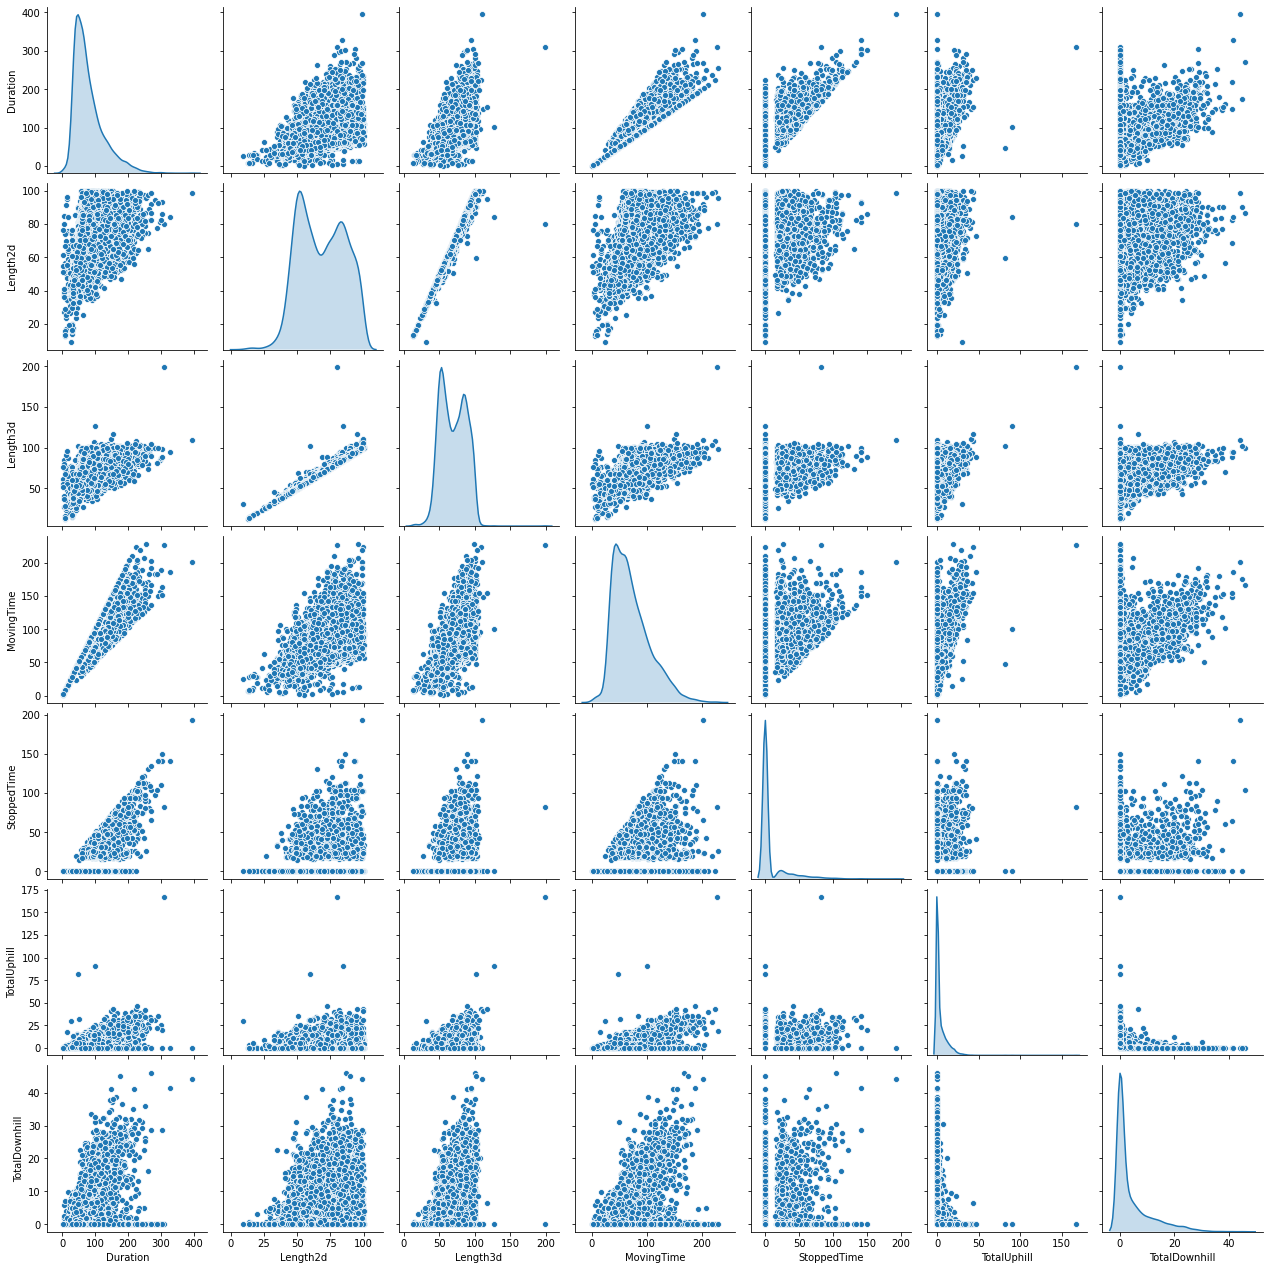

In [4]:
sns.pairplot(train_dataset[["Duration", "Length2d", "Length3d", "MovingTime", "StoppedTime", "TotalUphill", "TotalDownhill"]], diag_kind="kde")

All features show some correlation with the moving time and duration.

Also look at the overall feature statistics:

In [5]:
train_dataset_stats = train_dataset.describe()
train_dataset_stats.pop("MovingTime")
train_dataset_stats.pop("StoppedTime")
train_dataset_stats.pop("Duration")
train_dataset_stats = train_dataset_stats.transpose()
train_dataset_stats

,count,mean,std,min,25%,50%,75%,max
Length2d,5423.0,68.538888,17.220305,9.041167,53.476650,67.972200,83.300763,99.993868
Length3d,5423.0,69.628014,17.710744,12.903817,54.207306,69.118418,84.838200,198.873195
TotalUphill,5423.0,4.175006,7.131460,0.000000,0.000000,0.606669,5.933309,167.666667
TotalDownhill,5423.0,4.404140,6.881208,0.000000,0.000000,0.680013,6.276656,46.000081


### Split features from labels

Separate the target value, or "label", from the features. This label is the value that we will train the model to predict.

In [6]:
label_columns = ['MovingTime', 'StoppedTime', 'Duration']
train_labels_data = []
test_labels_data = []

for col_name in label_columns:
    train_labels_data.append(train_dataset.pop(col_name))
    test_labels_data.append(test_dataset.pop(col_name))

train_labels = pd.concat(train_labels_data, axis=1)
train_labels.sort_index(inplace=True)
test_labels = pd.concat(test_labels_data, axis=1)
test_labels.sort_index(inplace=True)

In [7]:
print(train_dataset.tail())
print(train_labels.tail())

       Length2d   Length3d  TotalUphill  TotalDownhill
5418  52.264453  53.381755     0.000000      10.733358
5419  91.418732  93.330839     0.000000      17.266683
5420  53.690754  54.113753     5.533285       0.000000
5421  52.206475  52.522497     5.733317       0.000000
5422  70.170335  70.517933     0.000000       6.733358
      MovingTime  StoppedTime  Duration
5418        58.0          0.0      58.0
5419       108.0          0.0     108.0
5420        52.0          0.0      52.0
5421        41.0          0.0      41.0
5422        68.0          0.0      68.0


### Normalize the data

The statistics about `train_dataset_stats` in the above block shows a wide variation of ranges for all features. Although a model *might* converge without feature normalization, the latter usually improves convergence properties.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution as the one the model has been trained on.

In [8]:
def norm(x):
    return (x - train_dataset_stats['mean']) / train_dataset_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

with open('train_stats_simple.csv', 'w') as csvfile:
    train_dataset_stats.to_csv(csvfile, sep=' ')

`normed_train_data` is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model. This includes the test dataset as well as input during inference. Thus we need to save the normalization numbers together with the model.

## The model

### Build the model

Let's build our model. In this notebook, we use a very simple multi-layer perceptron with a few fully connected layers. The last layer hast three units without activation function, suitable for a regression problem. for predicting duration, moving time and stopped time. The model building steps are wrapped in a function, `build_model`, for convencience.

In [9]:
learning_rate = 0.001

def build_model():
    statistics_inputs = layers.Input(shape=(train_dataset.shape[1],), name='StatisticsInput')
    dense1 = layers.Dense(32, activation=tf.nn.relu)(statistics_inputs)
    dense2 = layers.Dense(32, activation=tf.nn.relu)(dense1)
    dense3 = layers.Dense(32, activation=tf.nn.relu)(dense2)
    dense4 = layers.Dense(32, activation=tf.nn.relu)(dense3)
    outputs = layers.Dense(len(train_labels.keys()), activation=None)(dense4)
    
    model = models.Model(inputs=statistics_inputs, outputs=outputs)

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(loss='mean_squared_error', 
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

model = build_model()

How did we specify the architecture of the model?

The architecture is chosen such that we can reproduce esimates for walking times from a standard formula that is implemented in the function `compute_standard_walking_time` in `utils.py`.

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
StatisticsInput (InputLayer) [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 99        
Total params: 3,427
Trainable params: 3,427
Non-trainable params: 0
___________________________________________________________


Now try out the model. Take a batch of `4` examples from the training data and call `model.predict` on it.

In [11]:
example_batch = normed_train_data[:4]
example_result = model.predict(example_batch)
example_result

array([[ 0.13880397, -0.13430288, -0.07362196],
       [ 0.05409688, -0.10937167,  0.01839697],
       [ 0.00387421, -0.06835765, -0.0491894 ],
       [ 0.02233582, -0.09874827, -0.06604785]], dtype=float32)

### Train the model

Train the model for up to 500 epochs with the training set, and record the training and validation accuracy in the `history` object.

In [12]:
EPOCHS = 500

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                                 patience=20, min_lr=0.01*learning_rate)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40, verbose=1, 
                                                  restore_best_weights=True)

callbacks = [reduce_lr, early_stopping]


history = model.fit(normed_train_data.values, train_labels.values,
                    epochs=EPOCHS, validation_split = 0.2, verbose=1,
                    callbacks=callbacks)

Epoch 1/500
136/136 [==============================] - 0s 2ms/step - loss: 3091.4607 - mean_absolute_error: 38.6490 - mean_squared_error: 3091.4607 - val_loss: 730.9541 - val_mean_absolute_error: 18.0064 - val_mean_squared_error: 730.9541 - lr: 0.0010
Epoch 2/500
136/136 [==============================] - 0s 1ms/step - loss: 670.0352 - mean_absolute_error: 16.7260 - mean_squared_error: 670.0352 - val_loss: 622.7839 - val_mean_absolute_error: 16.1089 - val_mean_squared_error: 622.7839 - lr: 0.0010
Epoch 3/500
136/136 [==============================] - 0s 1ms/step - loss: 608.5651 - mean_absolute_error: 15.8422 - mean_squared_error: 608.5651 - val_loss: 594.4632 - val_mean_absolute_error: 15.7715 - val_mean_squared_error: 594.4632 - lr: 0.0010
Epoch 4/500
136/136 [==============================] - 0s 1ms/step - loss: 586.1762 - mean_absolute_error: 15.5241 - mean_squared_error: 586.1762 - val_loss: 576.4575 - val_mean_absolute_error: 15.1229 - val_mean_squared_error: 576.4575 - lr: 0.001

Epoch 34/500
136/136 [==============================] - 0s 1ms/step - loss: 498.7612 - mean_absolute_error: 14.0291 - mean_squared_error: 498.7612 - val_loss: 517.5383 - val_mean_absolute_error: 14.7184 - val_mean_squared_error: 517.5383 - lr: 0.0010
Epoch 35/500
136/136 [==============================] - 0s 1ms/step - loss: 498.9741 - mean_absolute_error: 14.0752 - mean_squared_error: 498.9741 - val_loss: 508.7059 - val_mean_absolute_error: 13.7376 - val_mean_squared_error: 508.7059 - lr: 0.0010
Epoch 36/500
136/136 [==============================] - 0s 1ms/step - loss: 499.8375 - mean_absolute_error: 13.9974 - mean_squared_error: 499.8375 - val_loss: 504.1957 - val_mean_absolute_error: 13.5304 - val_mean_squared_error: 504.1957 - lr: 0.0010
Epoch 37/500
136/136 [==============================] - 0s 1ms/step - loss: 500.4321 - mean_absolute_error: 14.0072 - mean_squared_error: 500.4321 - val_loss: 516.0917 - val_mean_absolute_error: 14.2577 - val_mean_squared_error: 516.0917 - lr: 0.0

Epoch 67/500
136/136 [==============================] - 0s 1ms/step - loss: 489.6899 - mean_absolute_error: 13.9222 - mean_squared_error: 489.6899 - val_loss: 494.9972 - val_mean_absolute_error: 14.0710 - val_mean_squared_error: 494.9972 - lr: 0.0010
Epoch 68/500
136/136 [==============================] - 0s 1ms/step - loss: 488.1986 - mean_absolute_error: 13.9102 - mean_squared_error: 488.1986 - val_loss: 495.5384 - val_mean_absolute_error: 14.0874 - val_mean_squared_error: 495.5384 - lr: 0.0010
Epoch 69/500
136/136 [==============================] - 0s 1ms/step - loss: 485.0537 - mean_absolute_error: 13.9522 - mean_squared_error: 485.0537 - val_loss: 490.0570 - val_mean_absolute_error: 13.5461 - val_mean_squared_error: 490.0570 - lr: 0.0010
Epoch 70/500
136/136 [==============================] - 0s 1ms/step - loss: 481.7892 - mean_absolute_error: 13.9285 - mean_squared_error: 481.7892 - val_loss: 492.8690 - val_mean_absolute_error: 13.4946 - val_mean_squared_error: 492.8690 - lr: 0.0

Epoch 100/500
136/136 [==============================] - 0s 1ms/step - loss: 471.3824 - mean_absolute_error: 13.8804 - mean_squared_error: 471.3824 - val_loss: 482.7194 - val_mean_absolute_error: 14.0300 - val_mean_squared_error: 482.7194 - lr: 0.0010
Epoch 101/500
136/136 [==============================] - 0s 1ms/step - loss: 471.7782 - mean_absolute_error: 13.8620 - mean_squared_error: 471.7782 - val_loss: 486.8200 - val_mean_absolute_error: 14.2269 - val_mean_squared_error: 486.8200 - lr: 0.0010
Epoch 102/500
136/136 [==============================] - 0s 1ms/step - loss: 471.7055 - mean_absolute_error: 13.8412 - mean_squared_error: 471.7055 - val_loss: 477.8445 - val_mean_absolute_error: 13.4236 - val_mean_squared_error: 477.8445 - lr: 0.0010
Epoch 103/500
136/136 [==============================] - 0s 1ms/step - loss: 469.1863 - mean_absolute_error: 13.8994 - mean_squared_error: 469.1863 - val_loss: 510.7646 - val_mean_absolute_error: 14.8426 - val_mean_squared_error: 510.7646 - lr:

136/136 [==============================] - 0s 1ms/step - loss: 457.6091 - mean_absolute_error: 13.8397 - mean_squared_error: 457.6091 - val_loss: 486.7902 - val_mean_absolute_error: 14.8683 - val_mean_squared_error: 486.7902 - lr: 0.0010
Epoch 133/500
136/136 [==============================] - 0s 1ms/step - loss: 459.5756 - mean_absolute_error: 13.8088 - mean_squared_error: 459.5756 - val_loss: 471.1175 - val_mean_absolute_error: 14.3519 - val_mean_squared_error: 471.1175 - lr: 0.0010
Epoch 134/500
136/136 [==============================] - 0s 1ms/step - loss: 459.3705 - mean_absolute_error: 13.7967 - mean_squared_error: 459.3705 - val_loss: 462.8400 - val_mean_absolute_error: 13.6178 - val_mean_squared_error: 462.8400 - lr: 0.0010
Epoch 135/500
136/136 [==============================] - 0s 1ms/step - loss: 454.7559 - mean_absolute_error: 13.7900 - mean_squared_error: 454.7559 - val_loss: 458.9513 - val_mean_absolute_error: 13.2841 - val_mean_squared_error: 458.9513 - lr: 0.0010
Epoch 

136/136 [==============================] - 0s 1ms/step - loss: 439.1454 - mean_absolute_error: 13.6245 - mean_squared_error: 439.1454 - val_loss: 473.7752 - val_mean_absolute_error: 14.9201 - val_mean_squared_error: 473.7752 - lr: 0.0010
Epoch 165/500
136/136 [==============================] - 0s 1ms/step - loss: 437.1047 - mean_absolute_error: 13.6319 - mean_squared_error: 437.1047 - val_loss: 446.8891 - val_mean_absolute_error: 13.2938 - val_mean_squared_error: 446.8891 - lr: 0.0010
Epoch 166/500
136/136 [==============================] - 0s 1ms/step - loss: 438.3864 - mean_absolute_error: 13.6469 - mean_squared_error: 438.3864 - val_loss: 448.0573 - val_mean_absolute_error: 14.1551 - val_mean_squared_error: 448.0573 - lr: 0.0010
Epoch 167/500
136/136 [==============================] - 0s 1ms/step - loss: 435.4749 - mean_absolute_error: 13.6482 - mean_squared_error: 435.4749 - val_loss: 439.6695 - val_mean_absolute_error: 13.4100 - val_mean_squared_error: 439.6695 - lr: 0.0010
Epoch 

136/136 [==============================] - 0s 1ms/step - loss: 429.1404 - mean_absolute_error: 13.5084 - mean_squared_error: 429.1404 - val_loss: 434.2628 - val_mean_absolute_error: 12.9468 - val_mean_squared_error: 434.2628 - lr: 0.0010
Epoch 197/500
136/136 [==============================] - 0s 1ms/step - loss: 424.8722 - mean_absolute_error: 13.3730 - mean_squared_error: 424.8722 - val_loss: 431.7343 - val_mean_absolute_error: 13.2545 - val_mean_squared_error: 431.7343 - lr: 5.0000e-04
Epoch 198/500
136/136 [==============================] - 0s 1ms/step - loss: 425.8810 - mean_absolute_error: 13.4365 - mean_squared_error: 425.8810 - val_loss: 433.0480 - val_mean_absolute_error: 13.3335 - val_mean_squared_error: 433.0480 - lr: 5.0000e-04
Epoch 199/500
136/136 [==============================] - 0s 1ms/step - loss: 424.8016 - mean_absolute_error: 13.3943 - mean_squared_error: 424.8016 - val_loss: 435.7693 - val_mean_absolute_error: 13.1283 - val_mean_squared_error: 435.7693 - lr: 5.000

136/136 [==============================] - 0s 1ms/step - loss: 421.0811 - mean_absolute_error: 13.3293 - mean_squared_error: 421.0811 - val_loss: 439.2018 - val_mean_absolute_error: 12.8800 - val_mean_squared_error: 439.2018 - lr: 5.0000e-04
Epoch 229/500
136/136 [==============================] - 0s 1ms/step - loss: 421.8974 - mean_absolute_error: 13.2886 - mean_squared_error: 421.8974 - val_loss: 436.8595 - val_mean_absolute_error: 13.1525 - val_mean_squared_error: 436.8595 - lr: 5.0000e-04
Epoch 230/500
136/136 [==============================] - 0s 1ms/step - loss: 421.6058 - mean_absolute_error: 13.3081 - mean_squared_error: 421.6058 - val_loss: 441.8975 - val_mean_absolute_error: 13.9298 - val_mean_squared_error: 441.8975 - lr: 5.0000e-04
Epoch 231/500
136/136 [==============================] - 0s 1ms/step - loss: 418.9995 - mean_absolute_error: 13.2750 - mean_squared_error: 418.9995 - val_loss: 435.5405 - val_mean_absolute_error: 13.6472 - val_mean_squared_error: 435.5405 - lr: 2

Visualize the model's training progress using the stats stored in the `history` object.

In [13]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,lr,epoch
245,419.004974,13.213395,419.004974,434.137207,13.491657,434.137207,0.00025,245
246,418.649353,13.241157,418.649353,433.647400,13.609379,433.647400,0.00025,246
247,417.965881,13.280797,417.965881,432.757416,13.473316,432.757416,0.00025,247
248,418.945038,13.287954,418.945038,432.414337,13.276932,432.414337,0.00025,248
249,417.002869,13.275594,417.002869,433.473907,13.205016,433.473907,0.00025,249


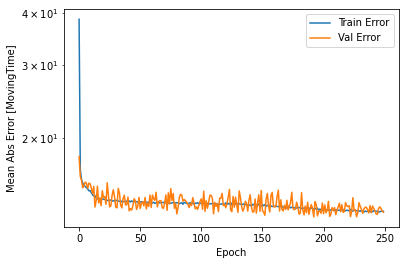

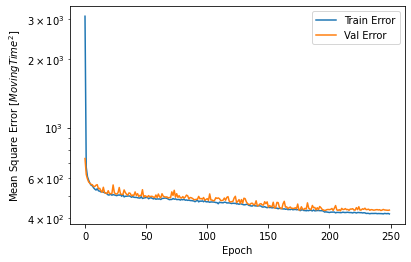

In [14]:
utils.plot_history(history)

As our data set of real GPX tracks is very small, the optimal choice of the epoch for ending training depends on the distribution of tracks between training, validation and testing data. The above choice led to quite stable results.


### Make predictions

Finally, predict walking time values using data in the testing set:

In [15]:
compute_standard_walking_time_vectorized = np.vectorize(utils.compute_standard_walking_time)

standard_estimate_walking_time = compute_standard_walking_time_vectorized(test_dataset['Length2d'].values,
                                                                          test_dataset['TotalUphill'].values,
                                                                          test_dataset['TotalDownhill'].values)

In [16]:
moving_stopped_duration_data_list = []
for index, data in test_labels.iterrows():
    moving_stopped_duration_data_list.append([data['MovingTime'], data['StoppedTime'], data['Duration']])
moving_stopped_duration_data = np.array(moving_stopped_duration_data_list)
moving_stopped_duration_data = np.transpose(moving_stopped_duration_data)


test_predictions = np.transpose(model.predict(normed_test_data))

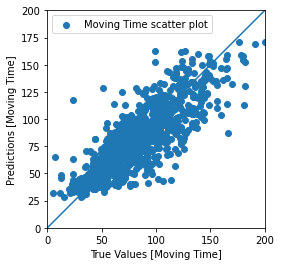

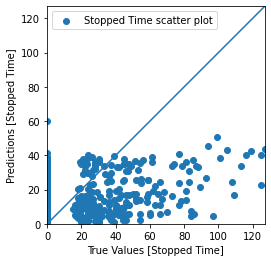

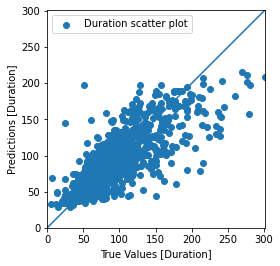

In [17]:
label_texts = ['Moving Time', 'Stopped Time', 'Duration']
    
for i in range(3):
    utils.scatter_plot(moving_stopped_duration_data[i], test_predictions[i], label_texts[i])

It looks like our model predicts reasonably well, as the results should be as close to the diagonal as possible. Let's take a look at the error distribution.

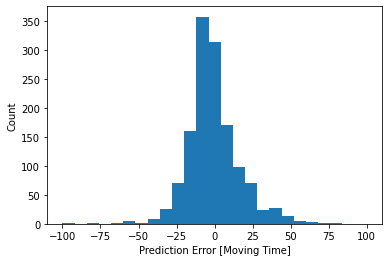

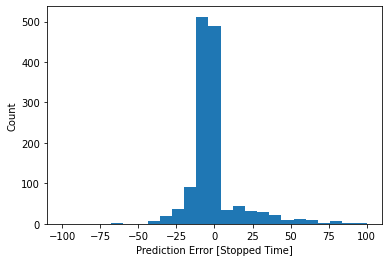

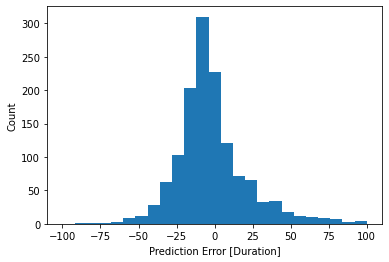

In [18]:
for i in range(3):
    utils.plot_error_hist(moving_stopped_duration_data[i], test_predictions[i], label_texts[i])

It's not quite gaussian, but we might expect that because the number of samples is very small.

Export model for use in inference:

In [19]:
model.save('model_hikingTimePrediction_simple.h5')

## Comparison of predictions with standard formula for predicting hiking durations

In the following, the predictions are compared with the estimates for hiking durations from a standard formula.

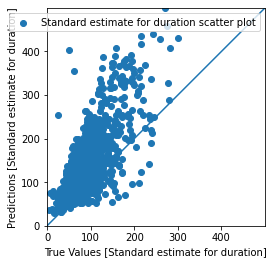

In [20]:
utils.scatter_plot(moving_stopped_duration_data[2], standard_estimate_walking_time, 'Standard estimate for duration')

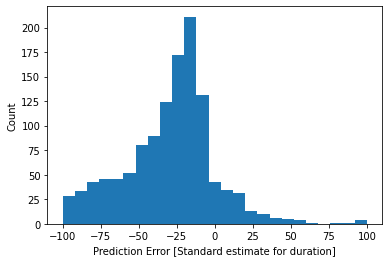

In [21]:
utils.plot_error_hist(moving_stopped_duration_data[2], 
                      standard_estimate_walking_time, 
                      'Standard estimate for duration')

## Conclusion

This notebook presents the training of an algorithm for predicting moving and stopping times as well as total duration for hiking (but it can also be applied to many other outdoor activities). We accomplished this by treating it as a regression problem and it is demonstrated that the model predictions are significantly better than those of a standard formulate for estimating hiking times. The other two notebooks present somewhat more sophisticated models that lead to better results.